In [2]:
!pip install rasterio
!pip install Pillow
!pip install -U tensorflow
!pip install -U keras
!pip install git+https://github.com/qubvel/segmentation_models

  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.13.1 which is incompatible.


  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-of9qim3t
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-of9qim3t
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [1]:
!pip install tensorflow==2.12.0

In [2]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.

In [5]:
import tensorflow as tf
import cv2
import matplotlib
import os, re
import rasterio
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show, show_hist
from sklearn.model_selection import train_test_split
import sys, traceback, signal
import keras
import segmentation_models as sm

dataset_path = "/content/drive/MyDrive/Tiles"

image_folder = os.path.join(dataset_path, "Rasters")
mask_folder = os.path.join(dataset_path, "Masks")

image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_folder))

# Check if the number of images and masks match
if len(image_files) != len(mask_files):
    raise ValueError("Number of images and masks don't match")

num_images = len(image_files)

# Lists to store the loaded images and masks
images = []
masks = []

for i in range(num_images):
    image_path = os.path.join(image_folder, image_files[i])
    mask_path = os.path.join(mask_folder, mask_files[i])

    # Open the image and mask using rasterio
    with rasterio.open(image_path) as src:
        image = src.read()  # Read all the channels

    with rasterio.open(mask_path) as src:
        mask = src.read(1)  # Read only the first channel (assuming the mask is single-channel)

    # Append the image and mask to the respective lists
    images.append(image)
    masks.append(mask)

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Print the shape of the loaded dataset
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

##########################################################
intX = np.array([tf.reshape(tf.convert_to_tensor(array), (256, 256, 6)) for array in images])
intY = np.array([tf.convert_to_tensor(array, dtype=np.uint8) for array in masks])
intxtrain, intxtest, intytrain, intytest = train_test_split(intX, intY, test_size=0.2, random_state=5)

##########################################################
BACKBONE = "inceptionv3"
preprocess = sm.get_preprocessing(BACKBONE)

############################################################
model = sm.Unet(backbone_name=BACKBONE, encoder_weights=None, input_shape=(256, 256, 6))
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
model.summary()

############################################################
intxtrain = preprocess(intxtrain)
intxtest = preprocess(intxtest)
intytrain = (intytrain / 255).astype(np.float32)
intytest = (intytest / 255).astype(np.float32)
intxval = intxtest[:(len(intxtest) // 2)]
intxtest = intxtest[(len(intxtest) // 2):len(intxtest)]
intyval = intytest[:(len(intytest) // 2)]
intytest = intytest[(len(intytest) // 2):len(intytest)]

#############################################################
history = model.fit(x=intxtrain, y=intytrain, batch_size=64, verbose=1, epochs=200, validation_data=(intxval, intyval))

# Save the model
model.save("smoke_inceptionv3_200epochs.h5")


Images shape: (1050, 6, 256, 256)
Masks shape: (1050, 256, 256)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 128, 128, 32  1728        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 128, 128, 32  96         ['conv2d_94[0][0]']              
 ormalization)              

Test IoU Score: 0.2327854335308075


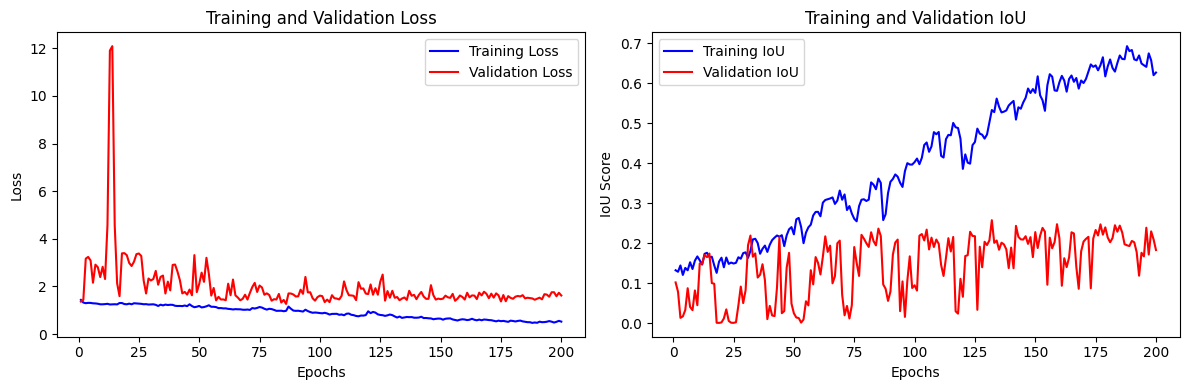

In [6]:
# Evaluate the model on the test set
score = model.evaluate(intxtest, intytest, verbose=0)
print("Test IoU Score:", score[1])

# Get the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_iou = history.history['iou_score']
val_iou = history.history['val_iou_score']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, train_iou, 'b-', label='Training IoU')
plt.plot(epochs, val_iou, 'r-', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()